In [3]:
# Using Machine Learning Models to Predict Hospital Readmission for pateints with Diabetes
# This study can be used to improve quality care of patients. We want to identify which patients have higher risks
# of readmission and provide a solution of that creates interventions monitarily assisting patients with these 
# increased risks. For this study we stick to patients with diabetes, affecting 10% of the US population.
# As a data science project, we use steps such as data cleasing, creating unique variables, dividing and sampling
# our dataset, and model evaluation. 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [4]:
df = pd.read_csv('/Users/erjonhome/Desktop/diabetic_data.csv')

In [5]:
print('Number of samples:',len(df))

Number of samples: 101766


In [6]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [7]:
# Count the number of rows fof each type
df.groupby('readmitted').size()

readmitted
<30    11357
>30    35545
NO     54864
dtype: int64

In [8]:
# This column shows where patients went after hospitalization. These rows are relateed to death and hospice, we remove these samples.
df= df.loc[~df.discharge_disposition_id.isin([11,13,14,19,20,21])]

In [9]:
# define an output variable to predict whether a patient is likely to be re-admitted within 30 days of discharge.
df['OUTPUT_LABEL'] = (df.readmitted == '<30').astype('int')

In [10]:
# Calculate prevalence of population that is readmitted in 30 days
def calc_prevalence(y_actual):
    return (sum(y_actual)/len(y_actual))

In [11]:
print('Prevalence:%.3f'%calc_prevalence(df['OUTPUT_LABEL'].values))

Prevalence:0.114


In [12]:
# Get rid of missing data
df = df.replace('?',np.nan)

In [13]:
# Gather numerical features
cols_num = ['time_in_hospital','num_lab_procedures','num_procedures','num_medications','number_outpatient','number_emergency','number_inpatient','number_diagnoses']

In [14]:
df[cols_num].isnull().sum()

time_in_hospital      0
num_lab_procedures    0
num_procedures        0
num_medications       0
number_outpatient     0
number_emergency      0
number_inpatient      0
number_diagnoses      0
dtype: int64

In [15]:
# Gather and transfrom non-numerical data into variables
cols_cat= ['race','gender',
'max_glu_serum',
'A1Cresult',
'metformin',
'repaglinide',
"nateglinide",
'chlorpropamide',
'glimepiride',
'acetohexamide',
'glipizide',
'glyburide',
'tolbutamide',
'pioglitazone',
'rosiglitazone',
'acarbose',
'miglitol',
'troglitazone',
'tolazamide',
'insulin',
'glyburide-metformin',
'glimepiride-pioglitazone',
'metformin-pioglitazone',
'glipizide-metformin',
'metformin-rosiglitazone',
'diabetesMed',
'change',
'payer_code']


In [16]:
# fill in the empty data for unknown
df['race'] = df['race'].fillna('UNK')
df['payer_code'] = df['payer_code'].fillna('UNK')
df['medical_specialty'] = df['medical_specialty'].fillna('UNK')

In [17]:
# Look at different values for medical specialty
print('NUmber medical specialty'), df.medical_specialty.nunique()
df.groupby('medical_specialty').size().sort_values(ascending = False)

NUmber medical specialty


medical_specialty
UNK                                 48616
InternalMedicine                    14237
Emergency/Trauma                     7419
Family/GeneralPractice               7252
Cardiology                           5279
                                    ...  
Surgery-PlasticwithinHeadandNeck        1
Dermatology                             1
Proctology                              1
Psychiatry-Addictive                    1
Speech                                  1
Length: 73, dtype: int64

In [18]:
#Only add the top 10 variables and "other" category. We don't want to add so many possible categories.

top_10 = ['UNK', 'InternalMedicine', 'Emergency/Trauma', \
'Family/GeneralPractice','Cardiology', 'Surgery-General',\
'Nephrology', 'Orthopedics',\
'Orthopedicg-Reconstructive', 'Radiologist']

#create new column with same data
df['med_spec'] = df['medical_specialty'].copy()
                    
# replace all specialties not in top 10 with 'Other" category
df.loc[~df.med_spec.isin(top_10),'med_spec'] = 'Other'

In [19]:
df.groupby('med_spec').size()

med_spec
Cardiology                 5279
Emergency/Trauma           7419
Family/GeneralPractice     7252
InternalMedicine          14237
Nephrology                 1539
Orthopedics                1392
Other                      9429
Radiologist                1121
Surgery-General            3059
UNK                       48616
dtype: int64

In [20]:
#one-hot encoding, create a new column for each unique value in that column. Build functions to help split our columns.
# get_dummies function works when we convert numerical data to string data
cols_cat_num = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']
df[cols_cat_num] = df[cols_cat_num].astype('str')

In [21]:
df_cat = pd.get_dummies(df[cols_cat + cols_cat_num + ['med_spec']],drop_first = True)

In [22]:
df_cat.head()

,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_UNK,gender_Male,gender_Unknown/Invalid,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,...,admission_source_id_9,med_spec_Emergency/Trauma,med_spec_Family/GeneralPractice,med_spec_InternalMedicine,med_spec_Nephrology,med_spec_Orthopedics,med_spec_Other,med_spec_Radiologist,med_spec_Surgery-General,med_spec_UNK
0,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [23]:
df_cat.head()

,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_UNK,gender_Male,gender_Unknown/Invalid,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,...,admission_source_id_9,med_spec_Emergency/Trauma,med_spec_Family/GeneralPractice,med_spec_InternalMedicine,med_spec_Nephrology,med_spec_Orthopedics,med_spec_Other,med_spec_Radiologist,med_spec_Surgery-General,med_spec_UNK
0,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [24]:
#add one-hot encoding columns to dataframe with concat
df = pd.concat([df,df_cat], axis = 1)

In [25]:
cols_all_cat = list(df_cat.columns)

In [26]:
# explore these last columns
df[['age', 'weight']].head()

,age,weight
0,[0-10),NaN
1,[10-20),NaN
2,[20-30),NaN
3,[30-40),NaN
4,[40-50),NaN


In [27]:
df.groupby('age').size()

age
[0-10)        160
[10-20)       690
[20-30)      1649
[30-40)      3764
[40-50)      9607
[50-60)     17060
[60-70)     22059
[70-80)     25331
[80-90)     16434
[90-100)     2589
dtype: int64

In [28]:
# Map out age groups 
age_id = {'[0-10)':0,
          '[10-20)':10,
          '[20-30)':20,
          '[30-40)':30,
          '[40-50)':40,
          '[50-60)':50,
          '[60-70)':60,
          '[70-80)':70,
          '[80-90)':80,
          '[90-100)':90}

df['age_group'] = df.age.replace(age_id)

In [29]:
# Weight column is not filled out often
df.weight.notnull().sum()

3125

In [30]:
# create variable that has weight inputted into dataset
df['has_weight'] = df.weight.notnull().astype('int')

In [31]:
cols_extra = ['age_group', 'has_weight']

In [32]:
# Created new features for the machine learning model: 
# 8 numerical, 133 categorical, 2 additonal 
# Making new dataframe to keep track
col2use = cols_num + cols_all_cat + cols_extra
df_data = df[col2use + ['OUTPUT_LABEL']]


In [33]:
df_data = df_data.sample(n = len(df_data), random_state = 52)
df_data = df_data.reset_index(drop = True)

In [34]:
# Time to split data in 3 parts:
# training: samples used to train model
# more info about training::::::::::::
# validation: held out from training and used to improve the model
# more info about validation::::::::::::
# test: used to measure performance of model
# For this model: We use 80% train, 10% Validation, 10% Test

# Shuffle the samples first
df_data = df_data.sample(n = len (df_data), random_state = 52)
df_data = df_data.reset_index(drop = True)

In [35]:
# Save 20% of the data as validation and test data
df_valid_test = df_data.sample(frac=0.20,random_state=52)
print('Split size: %.2f'%(len(df_valid_test)/len(df_data)))

Split size: 0.20


In [36]:
# Split the test and valdiation data in half
# '.drop' drops the rows not used in the sample
df_test = df_valid_test.sample(frac = 0.5,random_state=52)
df_valid = df_valid_test.drop(df_test.index)

In [37]:
# rest of data used in training data
df_train_all=df_data.drop(df_valid_test.index)

In [38]:
# split the training data into positive and negative
rows_pos = df_train_all.OUTPUT_LABEL == 1
df_train_pos = df_train_all.loc[rows_pos]
df_train_neg = df_train_all.loc[~rows_pos]

# merge the balanced data
df_train = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos), random_state = 52)], axis = 0)

#shuffle the order of training samples
df_train = df_train.sample(n = len(df_train), random_state = 52).reset_index(drop = True)

print('Train balanced prevalence (n = %d):%.2f'%(len(df_train), calc_prevalence(df_train.OUTPUT_LABEL.values)))

Train balanced prevalence (n = 18048):0.50


In [39]:
#Input matrix X and output vector y for machine learning models

X_train = df_train[col2use].values
X_train_all = df_train_all[col2use].values
X_valid = df_valid[col2use].values

y_train = df_train['OUTPUT_LABEL'].values
y_valid = df_valid['OUTPUT_LABEL'].values

print('Training All shapes:',X_train_all.shape)
print('Training shapes:',X_train.shape, y_train.shape)
print('Validation shapes:',X_valid.shape, y_valid.shape)

Training All shapes: (79474, 142)
Training shapes: (18048, 142) (18048,)
Validation shapes: (9935, 142) (9935,)


In [40]:
# Use standard scaler removing the mean and scales to unit variance
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train_all)

StandardScaler()

In [41]:
# Save scalar using pickle
import pickle
scalerfile = 'scaler.sav'
pickle.dump(scaler, open(scalerfile, 'wb'))

In [42]:
# reload it
scaler = pickle.load(open(scalerfile, 'rb'))

In [43]:
# Transform data matrixes 
X_train_tf = scaler.transform(X_train)
X_valid_tf = scaler.transform(X_valid)

In [44]:
# define classification metrics from scikit-learn to evaluate the perfromance of our models

from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
def calc_specificity(y_actual, y_pred, thresh):
    # calculate specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual==0)

def print_report(y_actual, y_pred, thresh):

    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC:%.2f'%auc)
    print('accuracy:%.2f'%accuracy)
    print('recall:%.2f'%recall)
    print('precision:%.2f'%precision)
    print('specificity:%.2f'%specificity)
    print('prevalence:%.2f'%calc_prevalence(y_actual))
    print(" ")
    return auc, accuracy, recall, precision, specificity


In [45]:
thresh = 0.5

In [46]:
# Compare the performance of 7 machine learning models
# KNN: supervised machine learing model
# pros: easy to use, little assumptions, works well for multi-class, can be used to classification and regression, 
# one hyper paramter, variety of distance criteria to chose from
# cons: curse of dimensionality, needs homgenous features, issues with imblaances data, outlier sensitivity,
# doesn't work well with missing data

from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors = 100)
knn.fit(X_train_tf, y_train)

KNeighborsClassifier(n_neighbors=100)

In [47]:
y_train_preds = knn.predict_proba(X_train_tf)[:,1]
y_valid_preds = knn.predict_proba(X_valid_tf)[:,1]

print('KNN')
print('Training:')
knn_train_auc, knn_train_accuracy, knn_train_recall, \
    knn_train_precision, knn_train_specificity = print_report(y_train, y_train_preds, thresh)
print('Validation:')
      
knn_valid_auc, knn_valid_accuracy, knn_valid_recall, \
    knn_valid_precision, knn_valid_specificity = print_report(y_valid, y_valid_preds, thresh)

KNN
Training:
AUC:0.65
accuracy:0.60
recall:0.49
precision:0.63
specificity:0.67
prevalence:0.50
 
Validation:
AUC:0.62
accuracy:0.67
recall:0.48
precision:0.17
specificity:0.65
prevalence:0.12
 


In [48]:
# Logistion Regression:
# pros: easy to use, works well for multi-class, fast at classifying unknowns, good accuracy for simple datasets
# cons: assumes linearity between dependent and independent variables, can only predict discret functions

from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(random_state = 52)
lr.fit(X_train_tf, y_train)

LogisticRegression(random_state=52)

In [49]:
y_train_preds = lr.predict_proba(X_train_tf)[:,1]
y_valid_preds = lr.predict_proba(X_valid_tf)[:,1]

print('LR')
print('Training:')
lr_train_auc, lr_train_accuracy, lr_train_recall, \
    lr_train_precision, lr_train_specificity = print_report(y_train, y_train_preds, thresh)
print('Validation:')
      
lr_valid_auc, lr_valid_accuracy, lr_valid_recall, \
    lr_valid_precision, lr_valid_specificity = print_report(y_valid, y_valid_preds, thresh)

LR
Training:
AUC:0.68
accuracy:0.62
recall:0.55
precision:0.64
specificity:0.69
prevalence:0.50
 
Validation:
AUC:0.66
accuracy:0.67
recall:0.54
precision:0.18
specificity:0.69
prevalence:0.12
 


In [50]:
# Naives Bayes
# pros: good for multi-class problems, very quick to compared to other algorithms, high accuracy when independency assumption holds
# cons: ndependency assumption isn't always true, zero-frequency issue of assigning zero probability to a categorical variable whose category in the test data set wasn’t available in the dataset

from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train_tf, y_train)

GaussianNB()

In [51]:
y_train_preds = nb.predict_proba(X_train_tf)[:,1]
y_valid_preds = nb.predict_proba(X_valid_tf)[:,1]

print('Naive Bayes')
print('Training:')
nb_train_auc, nb_train_accuracy, nb_train_recall, nb_train_precision, nb_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
nb_valid_auc, nb_valid_accuracy, nb_valid_recall, nb_valid_precision, nb_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Naive Bayes
Training:
AUC:0.50
accuracy:0.50
recall:0.99
precision:0.50
specificity:0.01
prevalence:0.50
 
Validation:
AUC:0.50
accuracy:0.13
recall:0.99
precision:0.12
specificity:0.01
prevalence:0.12
 


In [52]:
# Decision Tree Classifier
# pros: less data preparation needed, missing vlzues don't affect modeling, easy to interpret results
# cons: longer to train the model, doesn't work well with continuous values
# Max depth: Max depth represents the depth of each tree in the forest. 
# The deeper the tree the more information is taken into consideration about the data

from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth = 10, random_state = 52)
tree.fit(X_train_tf, y_train)

DecisionTreeClassifier(max_depth=10, random_state=52)

In [53]:
y_train_preds = tree.predict_proba(X_train_tf)[:,1]
y_valid_preds = tree.predict_proba(X_valid_tf)[:,1]

print('Decision Tree')
print('Training:')
tree_train_auc, tree_train_accuracy, tree_train_recall, tree_train_precision, tree_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
tree_valid_auc, tree_valid_accuracy, tree_valid_recall, tree_valid_precision, tree_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Decision Tree
Training:
AUC:0.73
accuracy:0.66
recall:0.57
precision:0.70
specificity:0.75
prevalence:0.50
 
Validation:
AUC:0.61
accuracy:0.67
recall:0.48
precision:0.17
specificity:0.69
prevalence:0.12
 


In [54]:
# Random Forest
# pros: works well with large datasets, lower risk of overfitting, less impacted by outliers
# cons: slow to train, takes longer to output results

from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(max_depth = 10, random_state = 52)
rf.fit(X_train_tf, y_train)

RandomForestClassifier(max_depth=10, random_state=52)

In [55]:
y_train_preds = rf.predict_proba(X_train_tf)[:,1]
y_valid_preds = rf.predict_proba(X_valid_tf)[:,1]

print('Random Forest')
print('Training:')
rf_train_auc, rf_train_accuracy, rf_train_recall, rf_train_precision, rf_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
rf_valid_auc, rf_valid_accuracy, rf_valid_recall, rf_valid_precision, rf_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Random Forest
Training:
AUC:0.76
accuracy:0.69
recall:0.65
precision:0.70
specificity:0.72
prevalence:0.50
 
Validation:
AUC:0.66
accuracy:0.64
recall:0.58
precision:0.18
specificity:0.65
prevalence:0.12
 


In [56]:
# Gradient Boosting Classifier
# pros: improved training on large datasets, supports categorical features, handles missing values well
# cons: prone to overfitting, difficult to scale up
# explain estimators, learning rate, max depth, we cant just add them for no reason

from sklearn.ensemble import GradientBoostingClassifier
gbc =GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
     max_depth=10, random_state=52)
gbc.fit(X_train_tf, y_train)

GradientBoostingClassifier(learning_rate=1.0, max_depth=10, random_state=52)

In [57]:
y_train_preds = gbc.predict_proba(X_train_tf)[:,1]
y_valid_preds = gbc.predict_proba(X_valid_tf)[:,1]

print('Gradient Boosting Classifier')
print('Training:')
gbc_train_auc, gbc_train_accuracy, gbc_train_recall, gbc_train_precision, gbc_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
gbc_valid_auc, gbc_valid_accuracy, gbc_valid_recall, gbc_valid_precision, gbc_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Gradient Boosting Classifier
Training:
AUC:1.00
accuracy:1.00
recall:1.00
precision:1.00
specificity:1.00
prevalence:0.50
 
Validation:
AUC:0.60
accuracy:0.58
recall:0.58
precision:0.15
specificity:0.58
prevalence:0.12
 


In [58]:
df_results = pd.DataFrame({'classifier':['KNN','KNN','LR','LR','NB','NB','DT','DT','RF','RF','GB','GB'],
                           'data_set':['train','valid']*6,
                          'auc':[knn_train_auc, knn_valid_auc,lr_train_auc,lr_valid_auc,nb_train_auc,nb_valid_auc,tree_train_auc,tree_valid_auc,rf_train_auc,rf_valid_auc,gbc_valid_auc,gbc_valid_auc,],
                          'accuracy':[knn_train_accuracy, knn_valid_accuracy,lr_train_accuracy,lr_valid_accuracy,nb_train_accuracy,nb_valid_accuracy,tree_train_accuracy,tree_valid_accuracy,rf_train_accuracy,rf_valid_accuracy,gbc_valid_accuracy,gbc_valid_accuracy,],
                          'recall':[knn_train_recall, knn_valid_recall,lr_train_recall,lr_valid_recall,nb_train_recall,nb_valid_recall,tree_train_recall,tree_valid_recall,rf_train_recall,rf_valid_recall,gbc_valid_recall,gbc_valid_recall,],
                          'precision':[knn_train_precision, knn_valid_precision,lr_train_precision,lr_valid_precision,nb_train_precision,nb_valid_precision,tree_train_precision,tree_valid_precision,rf_train_precision,rf_valid_precision,gbc_valid_auc,gbc_valid_precision,],
                          'specificity':[knn_train_specificity, knn_valid_specificity,lr_train_specificity,lr_valid_specificity,nb_train_specificity,nb_valid_specificity,tree_train_specificity,tree_valid_specificity,rf_train_specificity,rf_valid_specificity,gbc_valid_specificity,gbc_valid_specificity,]})

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")

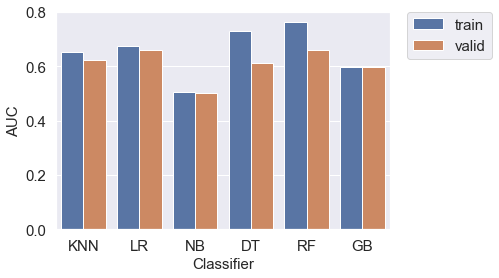

In [60]:
ax = sns.barplot(x="classifier", y="auc", hue="data_set", data=df_results)
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('AUC', fontsize = 15)
ax.tick_params(labelsize=15)

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)
plt.show()

In [67]:
# Generating a plot of the test and training curve 
# estimator: an object that is used  to find an estimate of unknown term with
# your given data. Could be a parameter, avector of parameters, a whole function
# X: a training vector
# Y: target relative to X for classification or regression
# ylim:  Defines minimum and maximum y-values plotted
# cv: iterable cross-validation generator: could be none, integer, an object 

import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
   
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training")
    plt.ylabel("AUC")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = 'roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="b")
    plt.plot(train_sizes, train_scores_mean, 'o-',
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-',
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

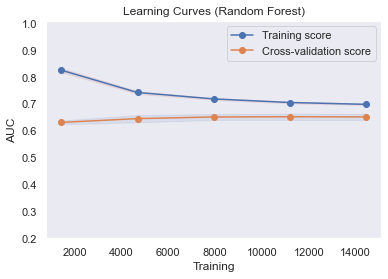

In [68]:
title = "Learning Curves (Random Forest)"
# Cross validation with 5 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=52)
estimator = RandomForestClassifier(max_depth = 6, random_state = 52)
plot_learning_curve(estimator, title, X_train_tf, y_train, ylim=(0.2, 1.01), cv=cv, n_jobs=4)

plt.show()

In [ ]:
# For Random Forest, training and validation scores are similar 
# but they both have low AUC scores. This is called high bias 
# and is a sign of underfitting.


In [69]:
# Investigate importance of model features
# we can use logistic regression to do this

feature_importances = pd.DataFrame(lr.coef_[0],
                                   index = col2use,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)

In [70]:
feature_importances.head()

,importance
number_inpatient,0.366062
discharge_disposition_id_22,0.202875
payer_code_UNK,0.161681
discharge_disposition_id_3,0.143007
glyburide_No,0.137327


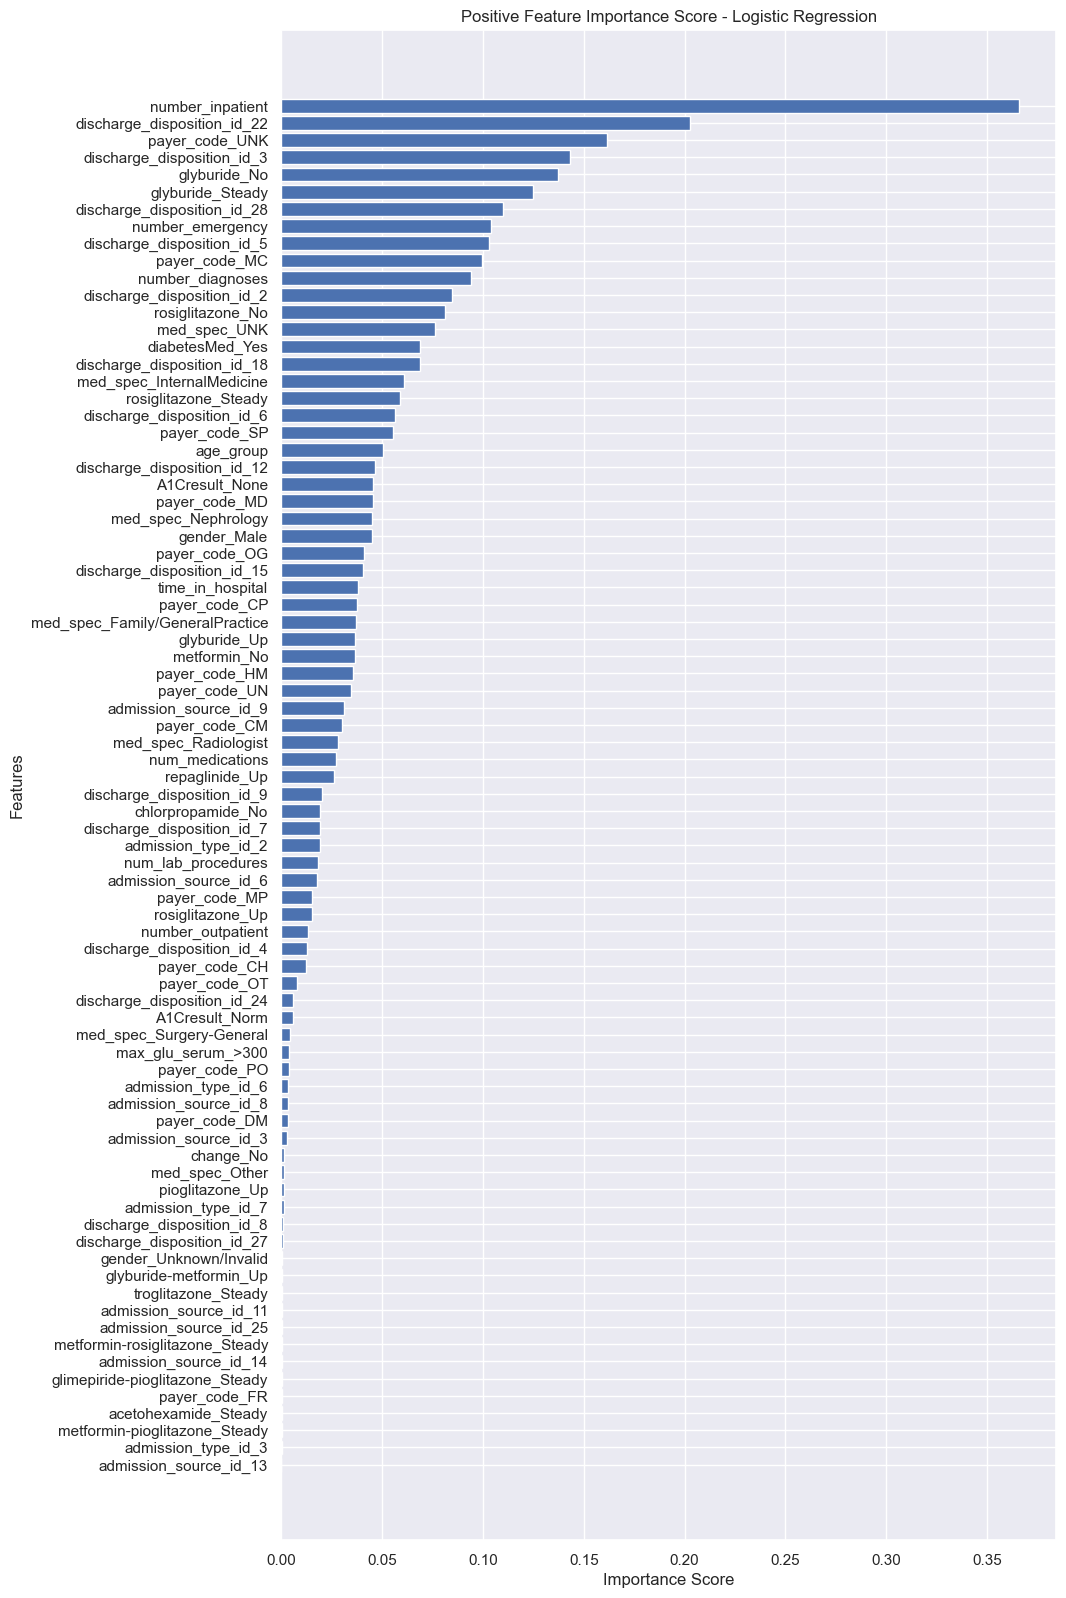

In [77]:
num = 80
ylocs = np.arange(num)
# get the feature importance for top num and sort in reverse order
values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(feature_importances.iloc[:num].index)[::-1]

plt.figure(num=None, figsize=(10, 20), dpi=100);
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Positive Feature Importance Score - Logistic Regression')
plt.yticks(ylocs, feature_labels)
plt.show()

In [ ]:
# Most important features to look at are 
#'number_inpatient' and 'discharge_disposition_id_22'
# These features are the numbers of patients visits last year and if 
# a patient was distributed into a rehbab facility. One strategy involves
# digging deeper into those features from additional hospital and admission data

In [79]:
# Hyperparameter Tuning:
# Look into the parameters for random forest

rf.get_params()


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 52,
 'verbose': 0,
 'warm_start': False}

In [81]:
# create a grid over a few of the random forest hyperparameters

from sklearn.model_selection import RandomizedSearchCV

# number of trees
n_estimators = range(100,1000,100)
# maximum number of features to use at each split
max_features = ['auto','sqrt']
# maximum depth of the tree
max_depth = range(1,10,1)
# minimum number of samples to split a node
min_samples_split = range(2,10,2)
# criterion for evaluating a split
criterion = ['gini','entropy']


random_grid = {'n_estimators':n_estimators,
              'max_features':max_features,
              'max_depth':max_depth,
              'min_samples_split':min_samples_split,
              'criterion':criterion}

print(random_grid)

{'n_estimators': range(100, 1000, 100), 'max_features': ['auto', 'sqrt'], 'max_depth': range(1, 10), 'min_samples_split': range(2, 10, 2), 'criterion': ['gini', 'entropy']}


In [82]:
from sklearn.metrics import make_scorer, roc_auc_score
auc_scoring = make_scorer(roc_auc_score)

In [83]:
# Create the randomized search cross-validation
# scoring = evaluation metric used to pick the best model
# n_iter = number of different combinations
# cv = number of cross-validation splits

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               n_iter = 20, cv = 2, scoring=auc_scoring,
                               verbose = 1, random_state = 52)

In [84]:
t1 = time.time()
rf_random.fit(X_train_tf, y_train)
t2 = time.time()
print(t2-t1)

Fitting 2 folds for each of 20 candidates, totalling 40 fits
108.49011468887329


In [86]:
rf_random.best_params_

{'n_estimators': 700,
 'min_samples_split': 6,
 'max_features': 'sqrt',
 'max_depth': 7,
 'criterion': 'entropy'}

In [87]:
y_train_preds = rf.predict_proba(X_train_tf)[:,1]
y_valid_preds = rf.predict_proba(X_valid_tf)[:,1]

print('Baseline Random Forest')
rf_train_auc_base = roc_auc_score(y_train, y_train_preds)
rf_valid_auc_base = roc_auc_score(y_valid, y_valid_preds)

print('Training AUC:%.3f'%(rf_train_auc_base))
print('Validation AUC:%.3f'%(rf_valid_auc_base))

print('Optimized Random Forest')
y_train_preds_random = rf_random.best_estimator_.predict_proba(X_train_tf)[:,1]
y_valid_preds_random = rf_random.best_estimator_.predict_proba(X_valid_tf)[:,1]

rf_train_auc = roc_auc_score(y_train, y_train_preds_random)
rf_valid_auc = roc_auc_score(y_valid, y_valid_preds_random)

print('Training AUC:%.3f'%(rf_train_auc))
print('Validation AUC:%.3f'%(rf_valid_auc))

Baseline Random Forest
Training AUC:0.762
Validation AUC:0.660
Optimized Random Forest
Training AUC:0.703
Validation AUC:0.656


In [89]:
# number of trees
n_estimators = range(100,500,100)

# maximum depth of the tree
max_depth = range(1,5,1)

# learning rate
learning_rate = [0.001,0.01,0.1]

# random grid

random_grid_gbc = {'n_estimators':n_estimators,
              'max_depth':max_depth,
              'learning_rate':learning_rate}

# create the randomized search cross-validation

gbc_random = RandomizedSearchCV(estimator = gbc, param_distributions = random_grid_gbc,
                                n_iter = 20, cv = 2, scoring=auc_scoring,
                                verbose = 0, random_state = 42)

t1 = time.time()
gbc_random.fit(X_train_tf, y_train)
t2 = time.time()
print(t2-t1)

215.28893995285034


In [90]:
gbc_random.best_params_

{'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}

In [91]:
y_train_preds = gbc.predict_proba(X_train_tf)[:,1]
y_valid_preds = gbc.predict_proba(X_valid_tf)[:,1]

print('Baseline Gradient Boosting Classifier')
gbc_train_auc_base = roc_auc_score(y_train, y_train_preds)
gbc_valid_auc_base = roc_auc_score(y_valid, y_valid_preds)

print('Training AUC:%.3f'%(gbc_train_auc_base))
print('Validation AUC:%.3f'%(gbc_valid_auc_base))

print('Optimized Gradient Boosting Classifier')
y_train_preds_random = gbc_random.best_estimator_.predict_proba(X_train_tf)[:,1]
y_valid_preds_random = gbc_random.best_estimator_.predict_proba(X_valid_tf)[:,1]
gbc_train_auc = roc_auc_score(y_train, y_train_preds_random)
gbc_valid_auc = roc_auc_score(y_valid, y_valid_preds_random)

print('Training AUC:%.3f'%(gbc_train_auc))
print('Validation AUC:%.3f'%(gbc_valid_auc))

Baseline Gradient Boosting Classifier
Training AUC:1.000
Validation AUC:0.596
Optimized Gradient Boosting Classifier
Training AUC:0.695
Validation AUC:0.665


In [98]:
df_results = pd.DataFrame({'classifier':['RF','RF','GB','GB'],
                           'data_set':['base','optimized']*2,
                          'auc':[rf_valid_auc_base,rf_valid_auc,
                                 gbc_valid_auc_base,gbc_valid_auc,],
                          })

In [99]:
df_results

,classifier,data_set,auc
0,RF,base,0.659587
1,RF,optimized,0.655771
2,GB,base,0.596477
3,GB,optimized,0.664983


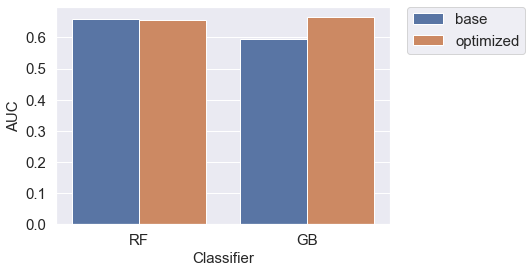

In [100]:
ax = sns.barplot(x="classifier", y="auc", hue="data_set", data=df_results)
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('AUC', fontsize = 15)
ax.tick_params(labelsize=15)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)

plt.show()

In [ ]:
# The most likely reason for the little to no improvement in AUC is from high bias in our data

In [101]:
pickle.dump(gbc_random.best_estimator_, open('best_classifier.pkl', 'wb'),protocol = 4)

In [102]:
X_test = df_test[col2use].values
y_test = df_test['OUTPUT_LABEL'].values

scaler = pickle.load(open('scaler.sav', 'rb'))
X_test_tf = scaler.transform(X_test)

In [103]:
best_model = pickle.load(open('best_classifier.pkl','rb'))

In [104]:
y_train_preds = best_model.predict_proba(X_train_tf)[:,1]
y_valid_preds = best_model.predict_proba(X_valid_tf)[:,1]
y_test_preds = best_model.predict_proba(X_test_tf)[:,1]

In [105]:
thresh = 0.5

print('Training:')
train_auc, train_accuracy, train_recall, train_precision, train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
valid_auc, valid_accuracy, valid_recall, valid_precision, valid_specificity = print_report(y_valid,y_valid_preds, thresh)
print('Test:')
test_auc, test_accuracy, test_recall, test_precision, test_specificity = print_report(y_test,y_test_preds, thresh)

Training:
AUC:0.70
accuracy:0.64
recall:0.57
precision:0.66
specificity:0.70
prevalence:0.50
 
Validation:
AUC:0.66
accuracy:0.67
recall:0.55
precision:0.19
specificity:0.68
prevalence:0.12
 
Test:
AUC:0.66
accuracy:0.67
recall:0.55
precision:0.19
specificity:0.69
prevalence:0.11
 


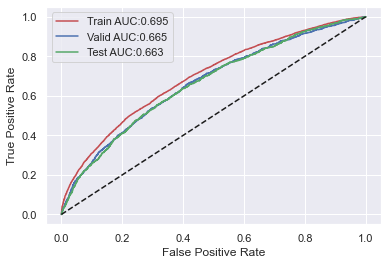

In [106]:
from sklearn.metrics import roc_curve 

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
auc_train = roc_auc_score(y_train, y_train_preds)

fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_preds)
auc_test = roc_auc_score(y_test, y_test_preds)

plt.plot(fpr_train, tpr_train, 'r-',label ='Train AUC:%.3f'%auc_train)
plt.plot(fpr_valid, tpr_valid, 'b-',label ='Valid AUC:%.3f'%auc_valid)
plt.plot(fpr_test, tpr_test, 'g-',label ='Test AUC:%.3f'%auc_test)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [ ]:
# Conclusion
# Created a binary classifier to predict the probability that a patient with diabetes would be readmitted 
# to the hospital within 30 days. On held out test data, our best model had an AUC of of 0.67. Using this model
# we are able to catch 57% of the readmissions from our model.
# This performs approximately 1.5 times better than randomly selecting patients.